In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'

# group_size = 1
# num_exps = 120
# num_repeats_per_exp = 5

group_size = 5
num_exps = 20
num_repeats_per_exp = 1

policies = [
    # 'ens jensen greedy',
    # 'classical ens',
    'greedy',
    'round robin greedy',
]
if group_size == 1 and 'round robin greedy' in policies:
    policies.remove('round robin greedy')
    
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 1000

basepath = os.path.join('../../data/results_1000', data)


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            labels = np.loadtxt(
                os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                dtype=int
            ).flatten() - 1

            utilities[p_ind, exp_ind, i, :] = log_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [4]:
utilities.shape

(2, 20, 1, 1001)

In [5]:
utilities[..., -1].mean(axis=(1, 2))

array([16.1262199, 16.6757392])

greedy: 16.1262
round robin greedy: 16.6757


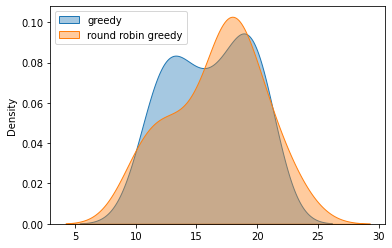

In [6]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=policy)
    
plt.legend(loc='upper left');

In [7]:
print(utilities.shape)
utilities

(2, 20, 1, 1001)


array([[[[ 0.69314718,  1.09861229,  1.38629436, ..., 13.17984707,
          13.18407541, 13.18828594]],

        [[ 0.69314718,  1.09861229,  1.38629436, ..., 17.81834659,
          17.81834659, 17.81834659]],

        [[ 0.69314718,  1.09861229,  1.38629436, ..., 12.30975676,
          12.30975676, 12.30975676]],

        ...,

        [[ 0.69314718,  1.09861229,  1.38629436, ..., 11.87318398,
          11.9272512 , 11.9272512 ]],

        [[ 0.69314718,  1.09861229,  1.38629436, ..., 14.46960917,
          14.46960917, 14.46960917]],

        [[ 0.69314718,  1.09861229,  1.38629436, ..., 19.85722254,
          19.8624719 , 19.86769384]]],


       [[[ 0.69314718,  0.69314718,  0.69314718, ..., 18.92557679,
          18.93165584, 18.93882433]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 17.91216495,
          17.91216495, 17.95868497]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 18.23963118,
          18.23963118, 18.23963118]],

        ...,

        [[ 0.693

In [8]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(2, 20, 1001)


array([[[ 0.69314718,  1.09861229,  1.38629436, ..., 13.17984707,
         13.18407541, 13.18828594],
        [ 0.69314718,  1.09861229,  1.38629436, ..., 17.81834659,
         17.81834659, 17.81834659],
        [ 0.69314718,  1.09861229,  1.38629436, ..., 12.30975676,
         12.30975676, 12.30975676],
        ...,
        [ 0.69314718,  1.09861229,  1.38629436, ..., 11.87318398,
         11.9272512 , 11.9272512 ],
        [ 0.69314718,  1.09861229,  1.38629436, ..., 14.46960917,
         14.46960917, 14.46960917],
        [ 0.69314718,  1.09861229,  1.38629436, ..., 19.85722254,
         19.8624719 , 19.86769384]],

       [[ 0.69314718,  0.69314718,  0.69314718, ..., 18.92557679,
         18.93165584, 18.93882433],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 17.91216495,
         17.91216495, 17.95868497],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 18.23963118,
         18.23963118, 18.23963118],
        ...,
        [ 0.69314718,  0.69314718,  0.69314718, ..., 1

In [9]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if squeezed_utilities[p1, :, -1].mean() < squeezed_utilities[p2, :, -1].mean():
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                squeezed_utilities[p1, :, -1], 
                squeezed_utilities[p2, :, -1],
                alternative=alternative
            ).pvalue
        )
    print()

greedy vs. round robin greedy
0.2690404206951613



14.575717107111078 17.676722686741517
0.7753
14.954489074633505 18.39698932282935
0.8606


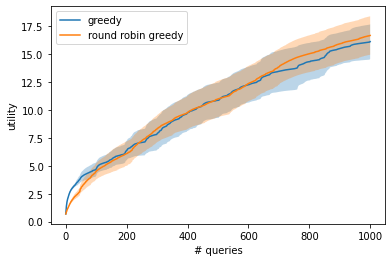

In [10]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print(f'{(upper[-1] - lower[-1]) / 4:.4f}')
    
plt.xlabel("# queries")
plt.ylabel("utility")
plt.legend();